# CNTK MNIST Example

In [1]:
import gzip
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os, os.path
import shutil
import struct
import sys

try:
    from urllib.request import urlretrieve
except ImportError:
    from urllib import urlretrieve

plt.ion()

## Download MNIST data

In [2]:
def loadData(gzfname):
    with gzip.open(gzfname) as gz:
        n = struct.unpack('I', gz.read(4))
        if n[0] != 0x3080000:
            raise Exception('Invalid file: unexpected magic number.')
        cimg = struct.unpack('>I', gz.read(4))[0]
        
        crow = struct.unpack('>I', gz.read(4))[0]
        ccol = struct.unpack('>I', gz.read(4))[0]
        if crow !=28 or ccol != 28:
            raise Exception('Invalid file: expected 28 rows/cols per image.')
        res = np.frombuffer(gz.read(cimg * crow * ccol), dtype = np.uint8)
        return res.reshape((cimg, crow * ccol))

def loadLabels(gzfname):
    with gzip.open(gzfname) as gz:
        n = struct.unpack('I', gz.read(4))
        if n[0] != 0x1080000:
            raise Exception('Invalid file: unexpected magic number.')
        cimg = struct.unpack('>I', gz.read(4))[0]
        res = np.frombuffer(gz.read(cimg), dtype=np.uint8)
        return res.reshape((cimg, 1))
    
def try_download(dirname):
    os.makedirs(dirname, exist_ok=True)
    base_addr = 'http://yann.lecun.com/exdb/mnist/'
    files = ['train-images-idx3-ubyte.gz','train-labels-idx1-ubyte.gz','t10k-images-idx3-ubyte.gz','t10k-labels-idx1-ubyte.gz']
    for fname in files:
        if not os.path.exists(os.path.join(dirname,fname)):
            print("Downloading "+base_addr+fname)
            urlretrieve(base_addr+fname, os.path.join(dirname,fname))
    train_data = loadData(os.path.join(dirname,files[0]))
    train_labels = loadLabels(os.path.join(dirname,files[1]))
    test_data = loadData(os.path.join(dirname,files[0]))
    test_labels = loadLabels(os.path.join(dirname,files[1]))
    return (train_data, train_labels, test_data, test_labels)
    

In [3]:
train_data, train_labels, test_data, test_labels = try_download('./MNIST-data')
train = np.hstack((train_data, train_labels))
test = np.hstack((test_data, test_labels))

## Visualize the data

Image Label:  5


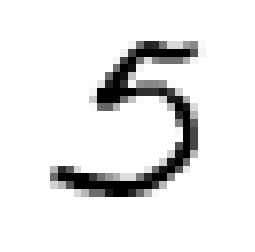

In [12]:
sample_number = np.random.randint(0, train.shape[0])
plt.imshow(train[sample_number,:-1].reshape(28,28), cmap="gray_r")
plt.axis('off')
print("Image Label: ", train[sample_number, -1])

## Save data files into a format compatible with CNTK text reader

In [7]:
def savetxt(filename, ndarray):
    dir = os.path.dirname(filename)
    if not os.path.exists(dir):
        os.makedirs(dir)
    
    print("Saving", filename)
    with open(filename, "w") as f:
        labels = list(map(' '.join, np.eye(10, dtype=np.uint).astype(str)))
        for row in ndarray:
            row_str = row.astype(str)
            label_str = labels[row[-1]]
            feature_str = ' '.join(row_str[:-1])
            f.write('|labels {} |features {}\n'.format(label_str, feature_str))

In [8]:
data_dir = "./MNIST-data"
savetxt(os.path.join(data_dir, "Train-28x28_cntk_text.txt"), train)
savetxt(os.path.join(data_dir, "Test-28x28_cntk_text.txt"), test)

Saving ./MNIST-data/Train-28x28_cntk_text.txt
Saving ./MNIST-data/Test-28x28_cntk_text.txt


# Lgistic Regression with MNIST

In [26]:
import cntk as C
import cntk.tests.test_utils
cntk.tests.test_utils.set_device_from_pytest_env()
C.cntk_py.set_fixed_random_seed(1) # fix the random seed so that LR examples are repeatable
input_dim = 784
num_output_classes = 10

train_file = "./MNIST-data/Train-28x28_cntk_text.txt"
test_file = "./MNIST-data/Test-28x28_cntk_text.txt"

In [15]:
def create_reader(path, is_training, input_dim, num_label_classes):
    """ Read a CTF formatted text using the CTF deserializer from a file"""
    labelStream = C.io.StreamDef(field='labels', shape=num_label_classes, is_sparse=False)
    featureStream = C.io.StreamDef(field='features', shape=input_dim, is_sparse=False)
    deserializer = C.io.CTFDeserializer(path, C.io.StreamDefs(labels=labelStream, features=featureStream))
    return C.io.MinibatchSource(deserializer, randomize=is_training, max_sweeps=C.io.INFINITELY_REPEAT if is_training else 1)

## Logistic Regression nework setup

In [21]:
image = C.input_variable(input_dim)
label = C.input_variable(num_output_classes)

def create_model(features):
    with C.layers.default_options(init=C.glorot_uniform()):
        r = C.layers.Dense(num_output_classes, activation=None)(features)
        return r

# Scale the input ot 0-1 range by dividing each pixel by 255.
z = create_model(image/255.0)
loss = C.cross_entropy_with_softmax(z, label)
label_error = C.classification_error(z, label)

In [24]:
learning_rate = 0.2
lr_schedule = C.learning_parameter_schedule(learning_rate)
learner = C.sgd(z.parameters, lr_schedule)
trainer = C.Trainer(z, (loss, label_error), [learner])

# Define a utility function to compute the moving average sum.
# A more efficient implementation is possible with np.cumsum() function
def moving_average(a, w=5):
    if len(a) < w:
        return a[:]  # Need to send a copy of the array
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]

# Defines a utility that prints the training progress
def print_training_progress(trainer, mb, frequency, verbose=1):
    training_loss = "NA"
    eval_error = "NA"
    
    if mb % frequency == 0:
        training_loss = trainer.previous_minibatch_loss_average
        eval_error = trainer.previous_minibatch_evaluation_average
        if verbose:
            print("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}%".format(mb, training_loss, eval_error*100))
    return mb, training_loss, eval_error        

## Run the trainer

In [42]:
minibatch_size = 64
num_samples_per_sweep = 60000
num_sweeps_to_train_with = 10
num_minibatches_to_train = (num_samples_per_sweep * num_sweeps_to_train_with) / minibatch_size

In [43]:
reader_train = create_reader(train_file, True, input_dim, num_output_classes)
input_map = {
    label: reader_train.streams.labels,
    image: reader_train.streams.features
}

training_progress_output_freq = 500

plotdata = {"batchsize":[], "loss":[], "error":[]}

for i in range(0, int(num_minibatches_to_train)):
    data = reader_train.next_minibatch(minibatch_size, input_map=input_map)
    trainer.train_minibatch(data)
    batchsize, loss, error = print_training_progress(trainer, i, training_progress_output_freq, verbose=1)
    
    if not (loss == "NA" or error == "NA"):
        plotdata["batchsize"].append(batchsize)
        plotdata["loss"].append(loss)
        plotdata["error"].append(error)

Minibatch: 0, Loss: 0.2991, Error: 9.38%
Minibatch: 500, Loss: 0.3246, Error: 9.38%
Minibatch: 1000, Loss: 0.3159, Error: 8.59%
Minibatch: 1500, Loss: 0.1936, Error: 6.25%
Minibatch: 2000, Loss: 0.3162, Error: 6.25%
Minibatch: 2500, Loss: 0.1637, Error: 5.47%
Minibatch: 3000, Loss: 0.1388, Error: 3.12%
Minibatch: 3500, Loss: 0.3840, Error: 7.81%
Minibatch: 4000, Loss: 0.1851, Error: 2.34%
Minibatch: 4500, Loss: 0.2396, Error: 7.03%


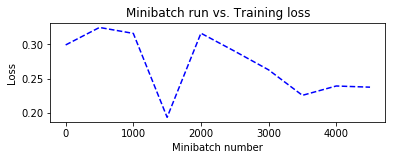

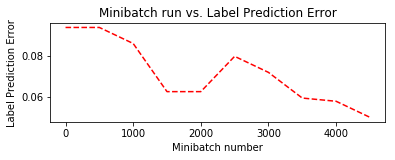

In [44]:
plotdata["avgloss"] = moving_average(plotdata["loss"])
plotdata["avgerror"] = moving_average(plotdata["error"])

import matplotlib.pyplot as plt

plt.figure(1)
plt.subplot(211)
plt.plot(plotdata["batchsize"], plotdata["avgloss"], 'b--')
plt.xlabel('Minibatch number')
plt.ylabel('Loss')
plt.title('Minibatch run vs. Training loss')
plt.show()
plt.subplot(212)
plt.plot(plotdata["batchsize"], plotdata["avgerror"], 'r--')
plt.xlabel('Minibatch number')
plt.ylabel('Label Prediction Error')
plt.title('Minibatch run vs. Label Prediction Error')
plt.show()

## Run evaluation / Testing

In [45]:
reader_test = create_reader(test_file, False, input_dim, num_output_classes)

test_input_map = {
    label: reader_test.streams.labels,
    image: reader_test.streams.features,
}

test_minibatch_size = 512
num_samples = 10000
num_minibatches_to_test = num_samples // test_minibatch_size
test_result = 0.0

for i in range(num_minibatches_to_test):
    data = reader_test.next_minibatch(test_minibatch_size, input_map=test_input_map)
    eval_error = trainer.test_minibatch(data)
    test_result = test_result + eval_error

print("Average test error: {0:.2f}%".format(test_result*100/ num_minibatches_to_test))

Average test error: 6.68%


In [46]:
out = C.softmax(z)

In [48]:
reader_eval = create_reader(test_file, False, input_dim, num_output_classes)

eval_minibatch_size = 25
# eval_input_map = { image: reader_eval.streams.features }

data = reader_test.next_minibatch(eval_minibatch_size, input_map = test_input_map)

img_label = data[label].asarray()
img_data = data[image].asarray()
predicted_label_prob = [out.eval(img_data[i]) for i in range(len(img_data))]

pred = [np.argmax(predicted_label_prob[i]) for i in range(len(predicted_label_prob))]
gtlabel = [np.argmax(img_label[i]) for i in range(len(img_label))]

print("Label    :", gtlabel[:25])
print("Predicted:", pred)

Label    : [0, 9, 1, 2, 2, 9, 3, 6, 4, 8, 5, 8, 6, 3, 7, 7, 8, 5, 9, 2, 0, 7, 1, 2, 2]
Predicted: [0, 9, 1, 2, 2, 9, 3, 4, 4, 8, 5, 8, 6, 3, 7, 7, 8, 3, 9, 2, 0, 2, 1, 2, 2]


Image Label: 5, Predicted Label: 3


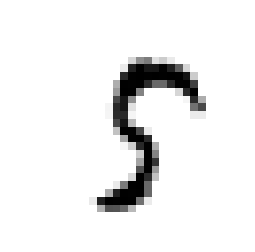

In [49]:
sample_number = 17
plt.imshow(img_data[sample_number].reshape(28,28), cmap='gray_r')
plt.axis('off')
img_gt, img_pred = gtlabel[sample_number], pred[sample_number]
print("Image Label: {0}, Predicted Label: {1}".format(img_gt, img_pred))